# Time Series Analysis - ARIMA, Autocorrelation - Lag variables extraction
List of things I did in this notebook:
* Starting again from train.csv because 0-sales are needed in a Time series modeling
* Trends analysis to identify main seasonality
* Get the seasonality adjusted time series
* Correlogram, ACF, PACF
* Identification of possible interesting lag variables
* Lag variables extraction
* Evaluation of goodness of lag variables through Random Forest Regression
* Saved a new preprocessed train set called *Arima_prep_train.csv*
## This lag vars will have to be extracted on the plain dataset, not in sumofstores which is only used to enhance the behavior and better find good lag vars representatives

In [1]:
# line plot of time series
from pandas import Series
import pandas as pd
import matplotlib.pyplot as plt
# load dataset
dataset = pd.read_csv('./dataset/preprocessed_train.csv')

In [6]:
#dataset['Date'] = pd.to_datetime(dataset['Date'],format='%d/%m/%Y')
dataset.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,1000,2016-03-01,0,1,0,Hyper Market,General,326,7,495.000000,...,0,1,0,0,1,0,0,1,0,0
1,1000,2016-03-02,0,1,0,Hyper Market,General,326,7,608.000000,...,0,0,1,0,1,0,0,1,0,0
2,1000,2016-03-04,0,1,0,Hyper Market,General,326,7,665.000000,...,0,0,0,0,1,0,0,1,0,0
3,1000,2016-03-05,0,1,0,Hyper Market,General,326,7,630.000000,...,0,0,0,0,1,0,0,1,0,0
4,1000,2016-03-06,0,0,0,Hyper Market,General,326,7,622.769231,...,0,0,0,0,1,0,0,1,0,0


In [7]:
dataset.shape

(523021, 48)

In [8]:
aggregation_dict = {'NumberOfSales':sum,      # find the sum of the sales of the group
                    'NumberOfCustomers':sum,
                    'StoreID':"count"}
sumofstores = dataset.groupby('Date').agg(aggregation_dict)
sumofstores = sumofstores.reset_index()
sumofstores['Date'] = pd.to_datetime(sumofstores['Date'], errors='coerce')  #important otherwise no ticks
sumofstores.head(10)

,Date,NumberOfSales,NumberOfCustomers,StoreID
0,2016-03-01,2.872089e+06,201096.909125,749
1,2016-03-02,3.404998e+06,227678.909125,749
2,2016-03-04,3.476751e+06,233679.909125,749
3,2016-03-05,3.207761e+06,209036.909125,749
4,2016-03-06,3.656088e+06,231726.955333,749
5,2016-03-07,5.302271e+06,303882.909125,749
6,2016-03-08,4.297697e+06,263026.667990,749
7,2016-03-09,3.874509e+06,243974.667990,749
8,2016-03-10,3.829557e+06,244163.667990,749
9,2016-03-11,3.891613e+06,248169.667990,749


In [9]:
#Sampling
sample=sumofstores.iloc[:200]

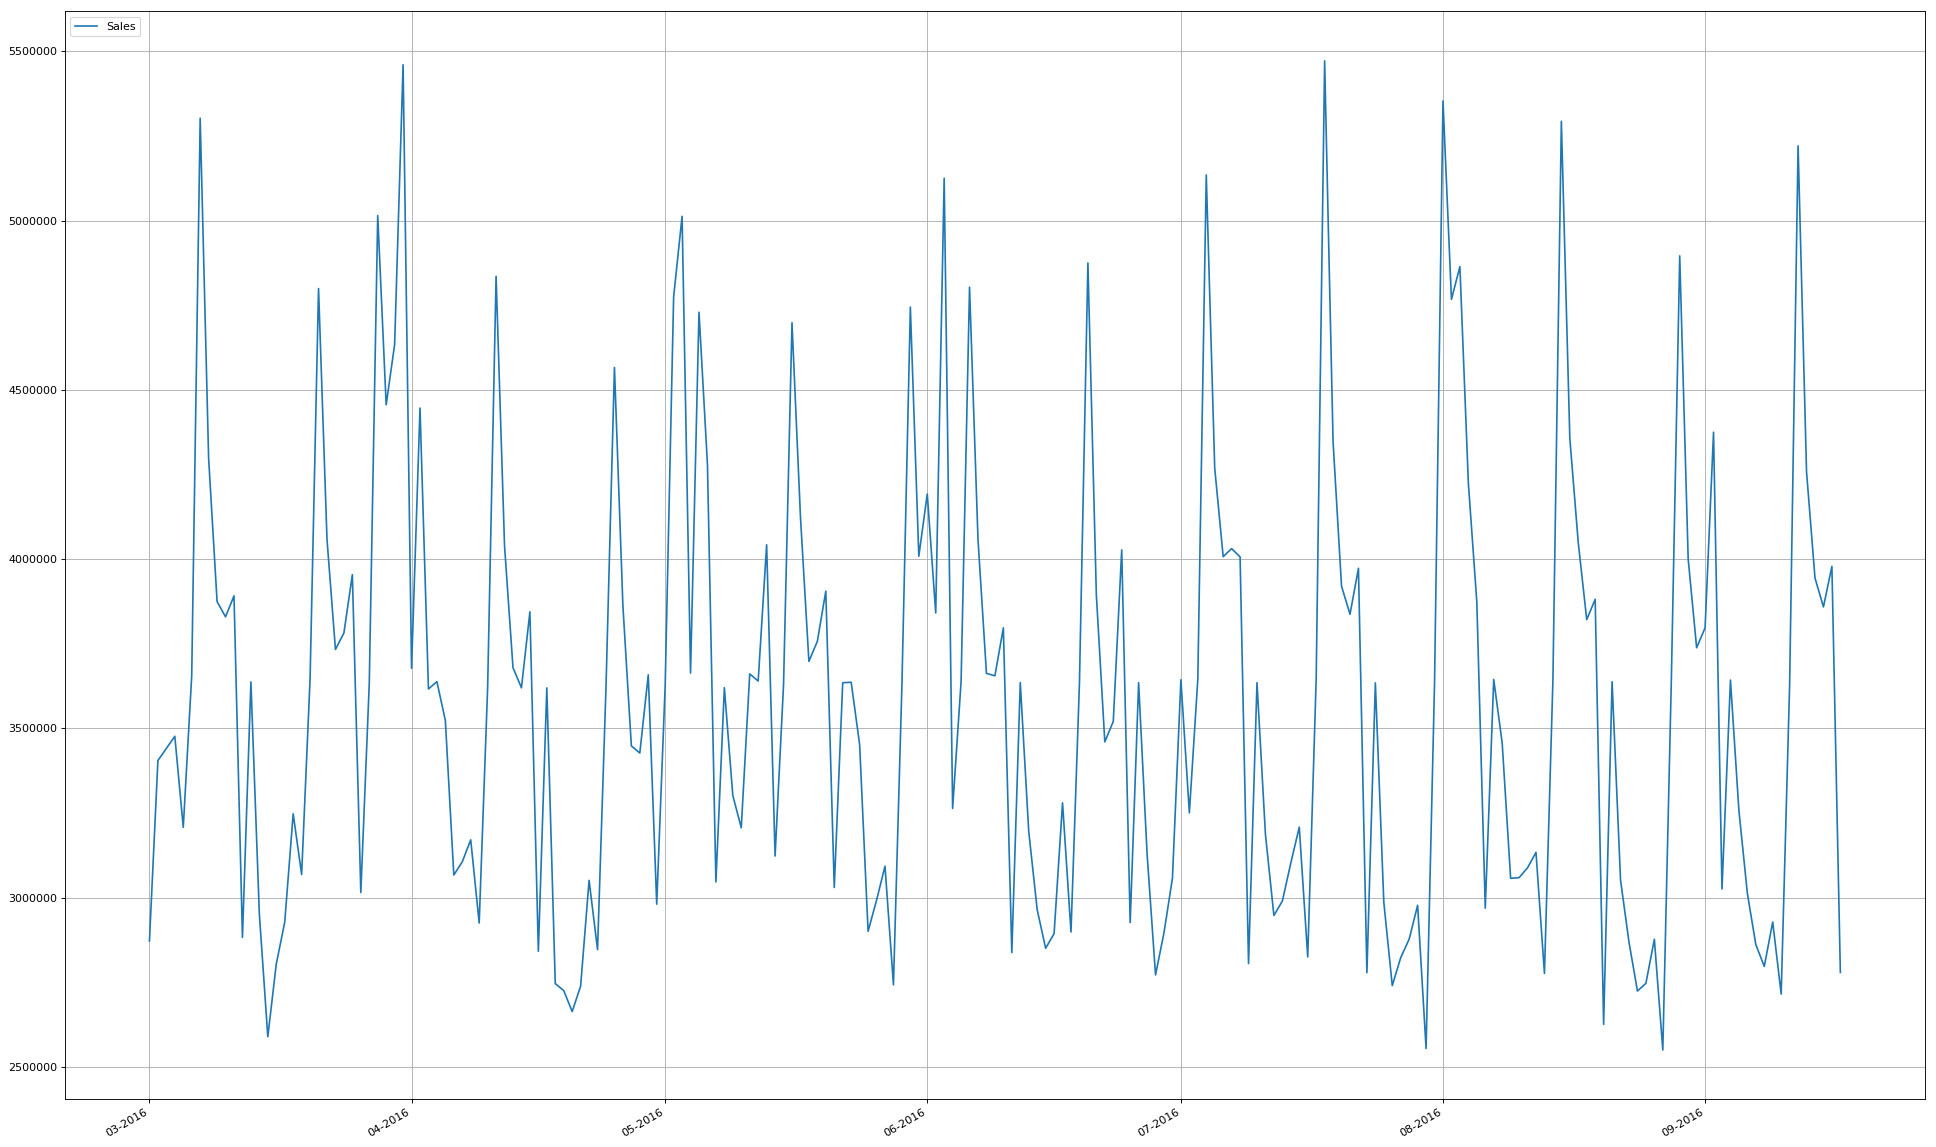

In [10]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
monthsFmt = mdates.DateFormatter('%m')
yearsFmt = mdates.DateFormatter('%Y')
monthsYearFmt = mdates.DateFormatter('%m-%Y')

plt.rcParams['figure.figsize'] = [30.0,20.0]
plt.rcParams['figure.dpi']=80
fig, ax = plt.subplots()
    
# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsYearFmt)
ax.xaxis.set_minor_locator(months)
    
ax.plot(sample.Date, sample.NumberOfSales)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsYearFmt)
ax.xaxis.set_minor_locator(months)
ax.grid(True)
plt.legend(['Sales'], loc='upper left')

fig.autofmt_xdate()
plt.show()

## Autocorrelation plot (Correlogram)
It shows the correlation of each lagged observation and whether or not the correlation is statistically significant.

C:\Users\Mirko\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


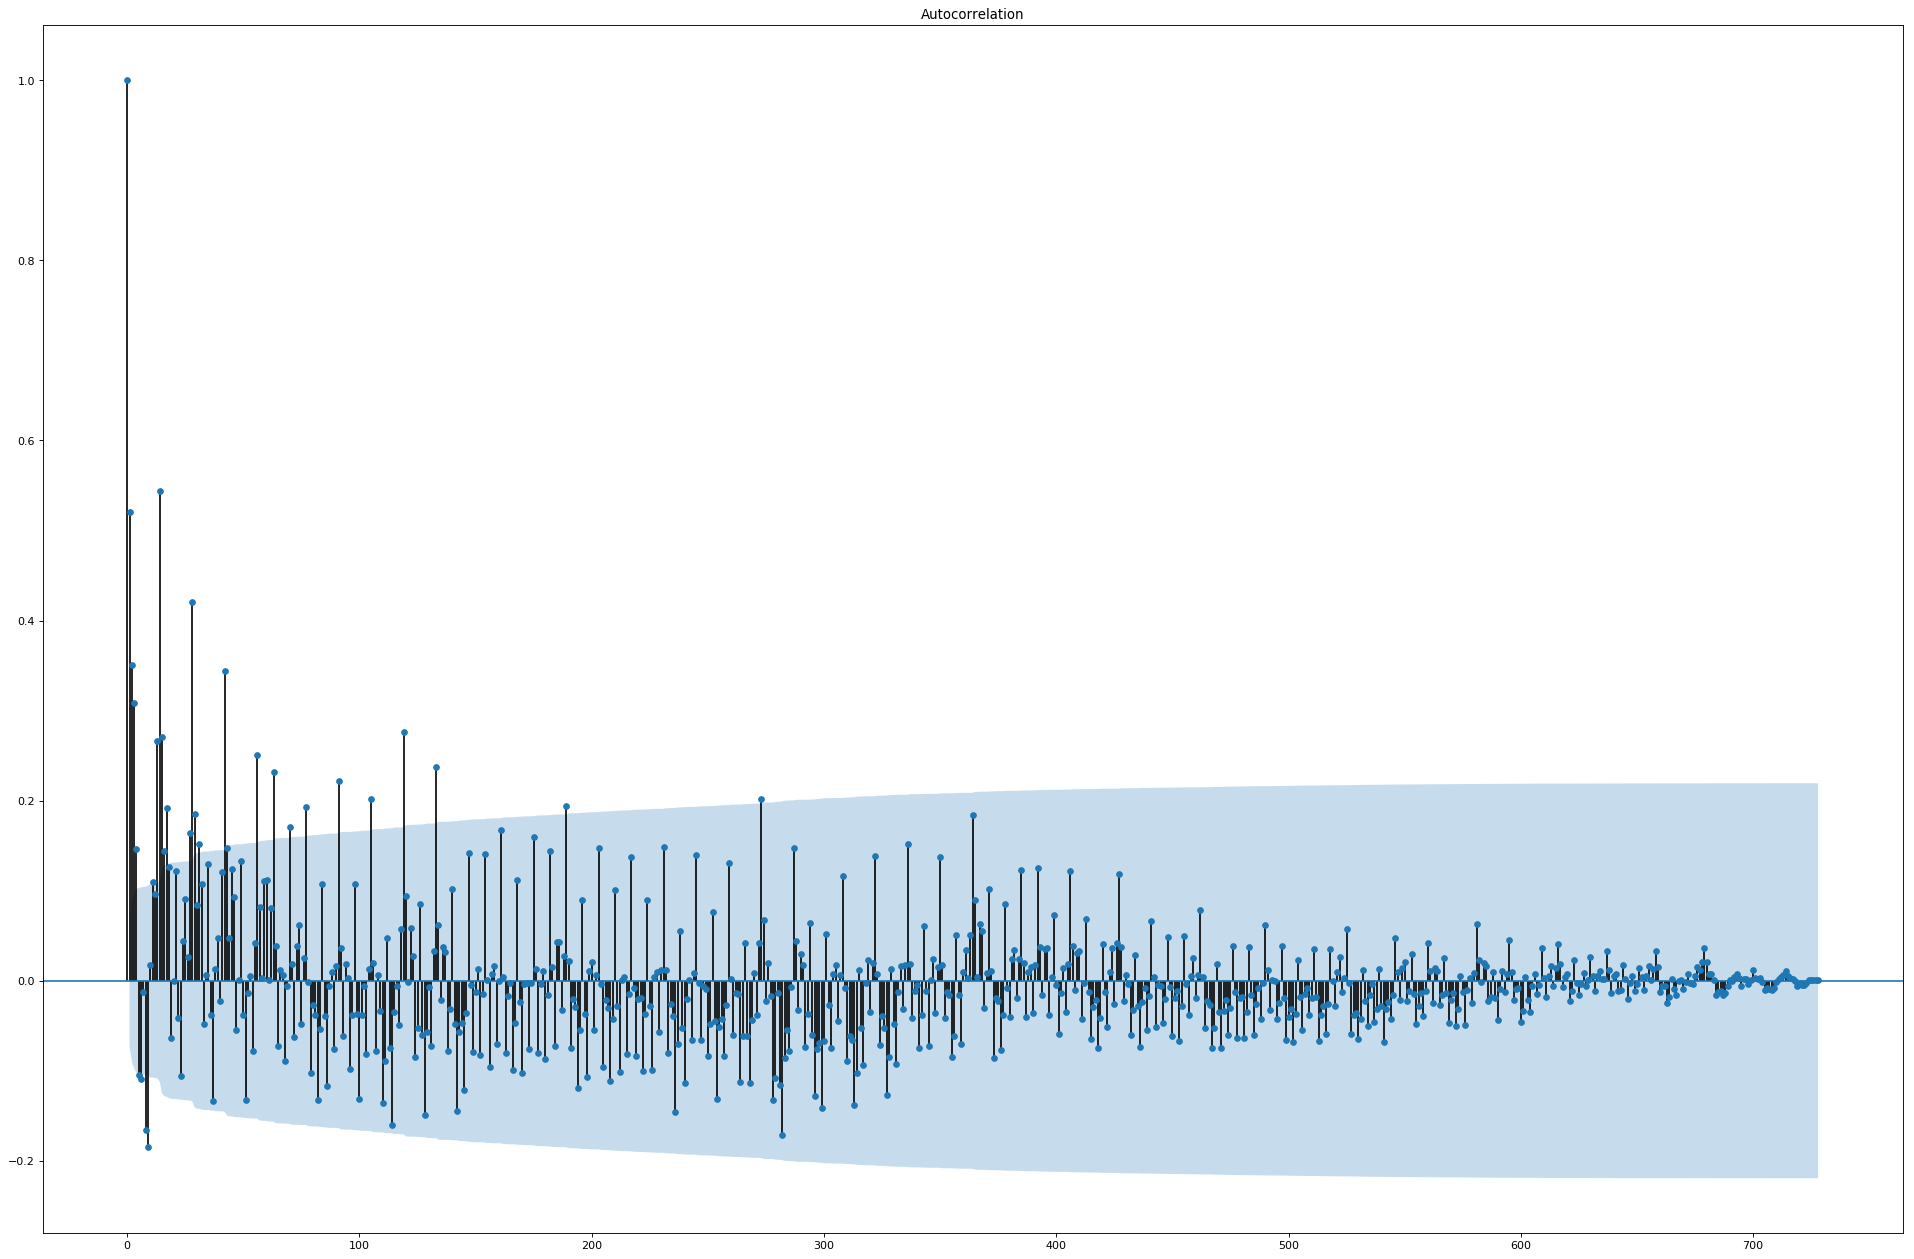

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sumofstores['NumberOfSales'])
plt.show()

Since the ACF pattern clearly show a linear autocorrelation decay, the analysis must be performed on a differentiation

## Removing seasonality and trend, stationary Time Series
The main seasonality is clearly on the week (monday-sunday), let's create a seasonality adjusted time series

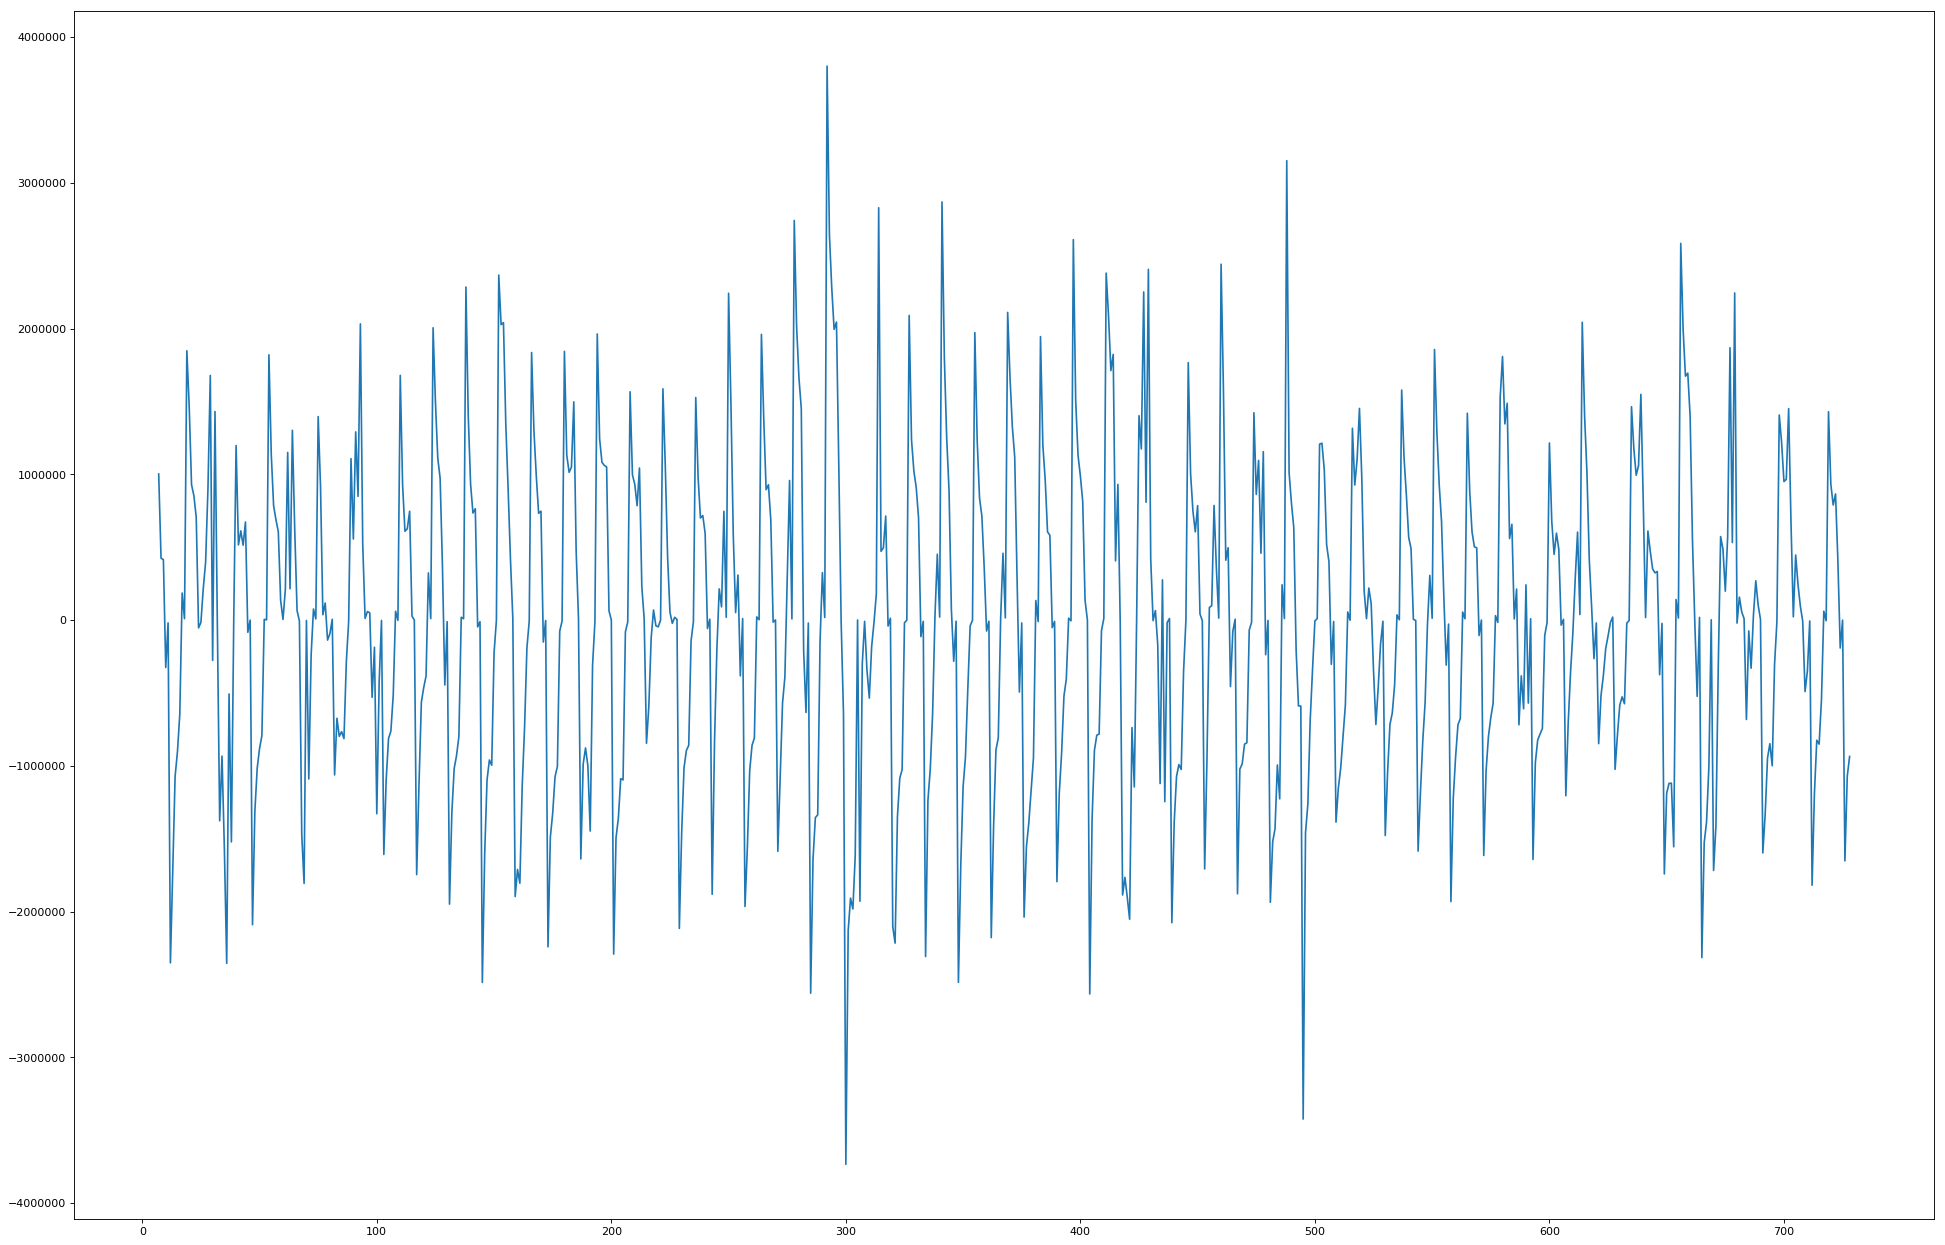

In [13]:
# seasonal difference
differenced = sumofstores.NumberOfSales.diff(7)
# trim off the first year of empty data
differenced = differenced[7:]
# save differenced dataset to file
#differenced.to_csv('seasonally_adjusted.csv')
# plot differenced dataset
differenced.plot()
plt.show()

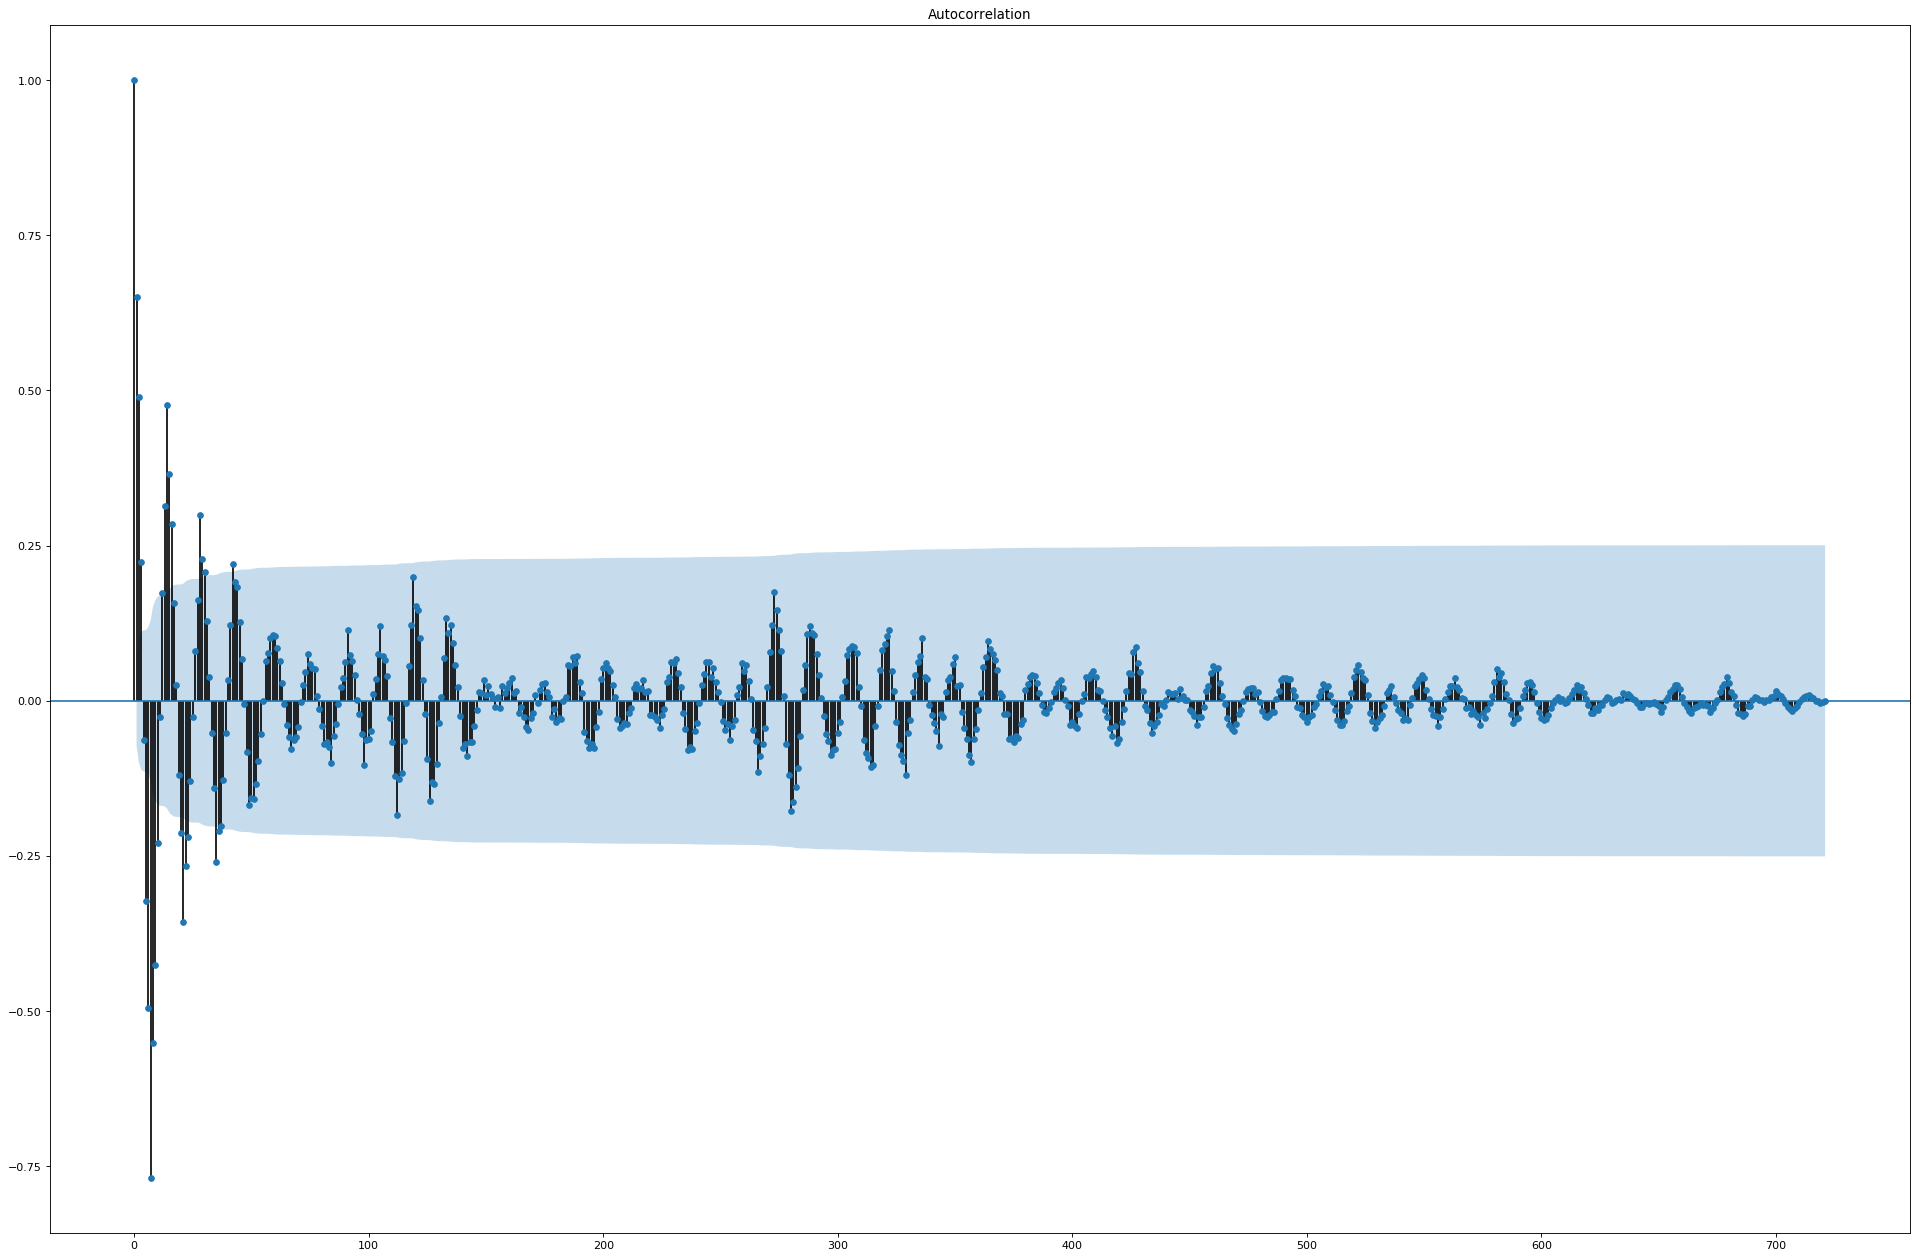

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(differenced)
plt.show()

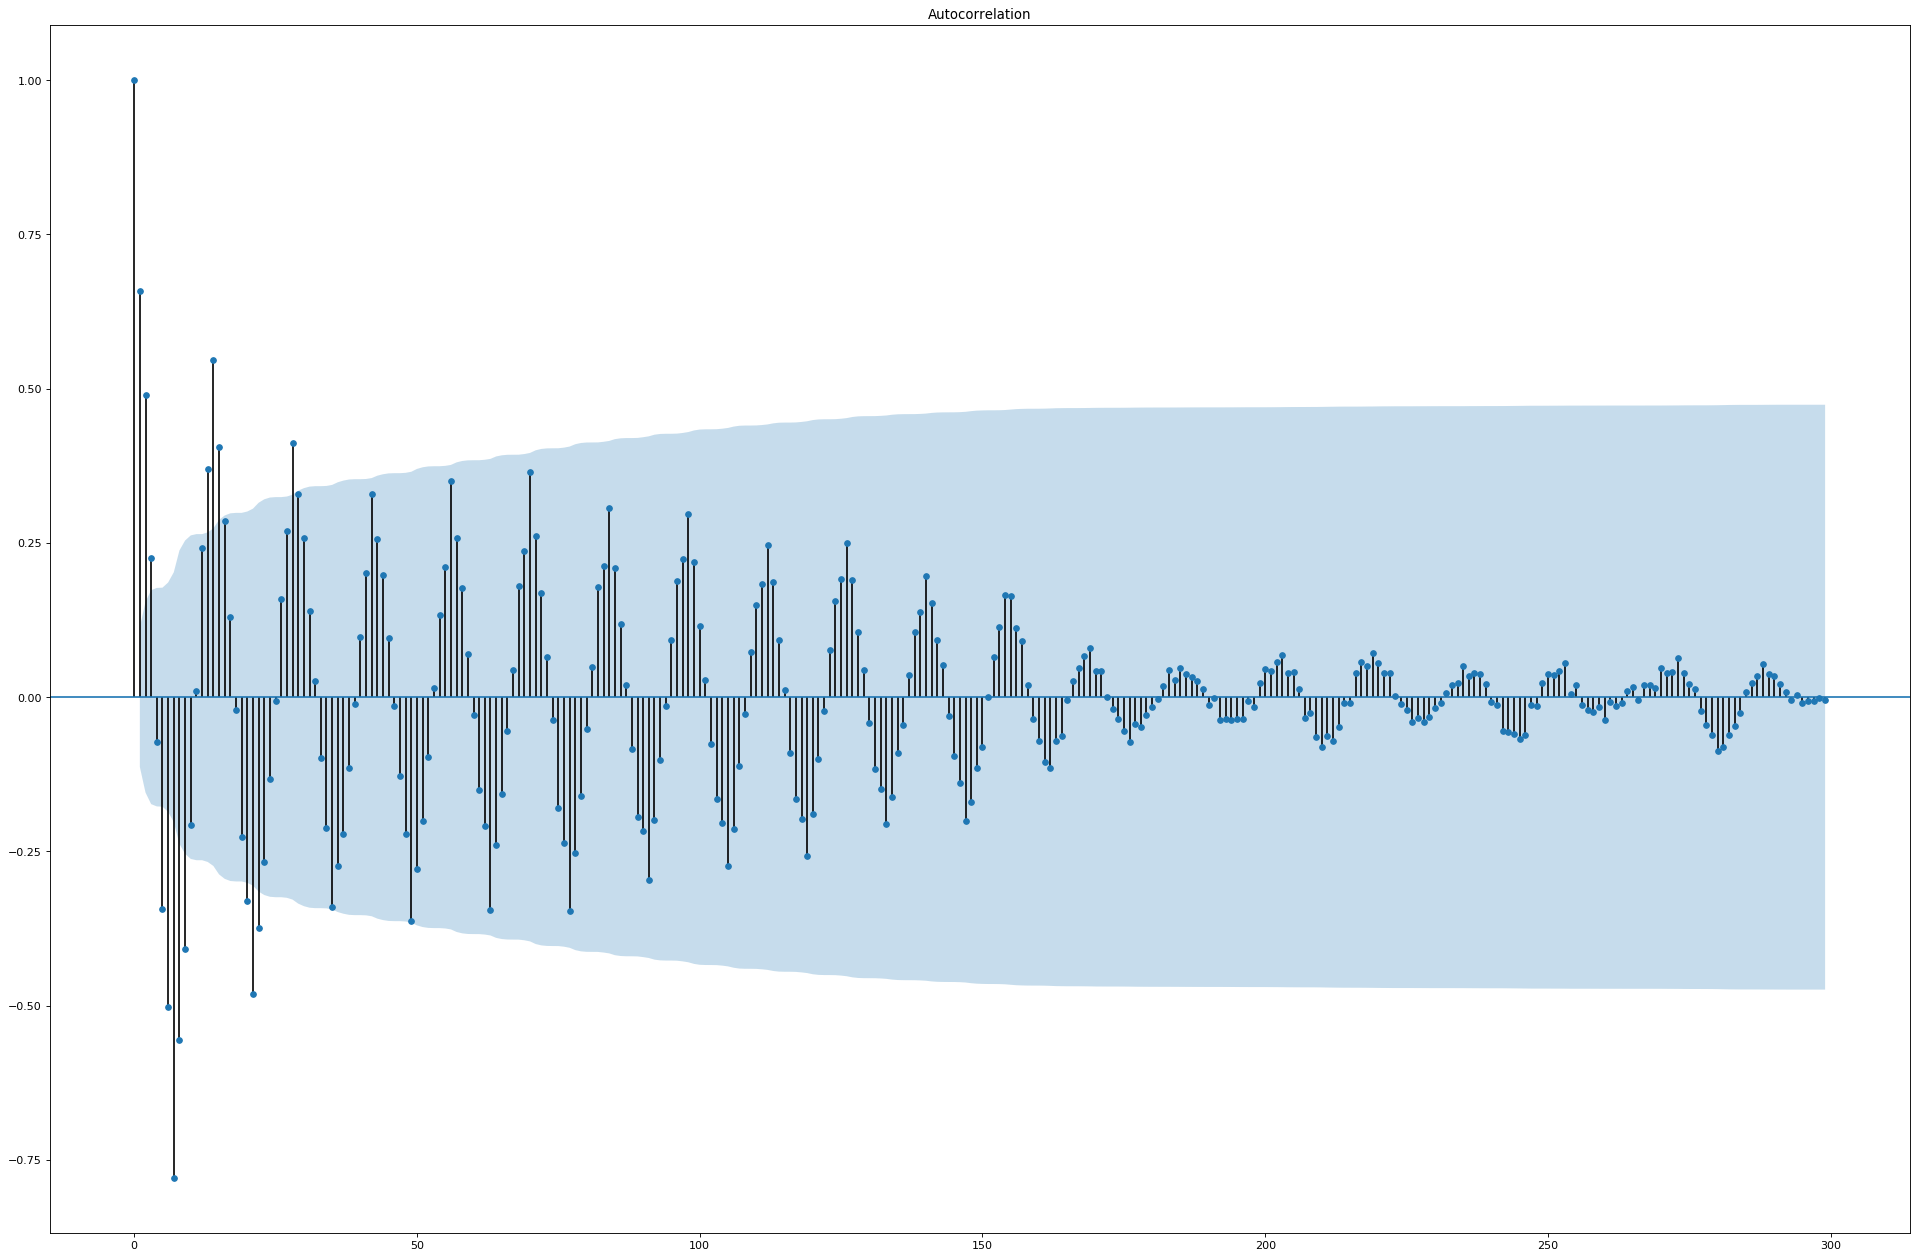

In [15]:
plot_acf(differenced[:300])
plt.show()

__The most important (statistically significant) lags identified are__ 
* 1,2,3,5,6,7,8,9,13,14,15,20,21

__Among these, the best ones are__
* 1,2,7,14

__In order of importance:__
* 7,14,1,2,9,8,6,15,21,13,20

__we have to keep in mind that 0-sales have to be reincluded in the training before computing the lags and inserting them__

## Partial autocorrelation

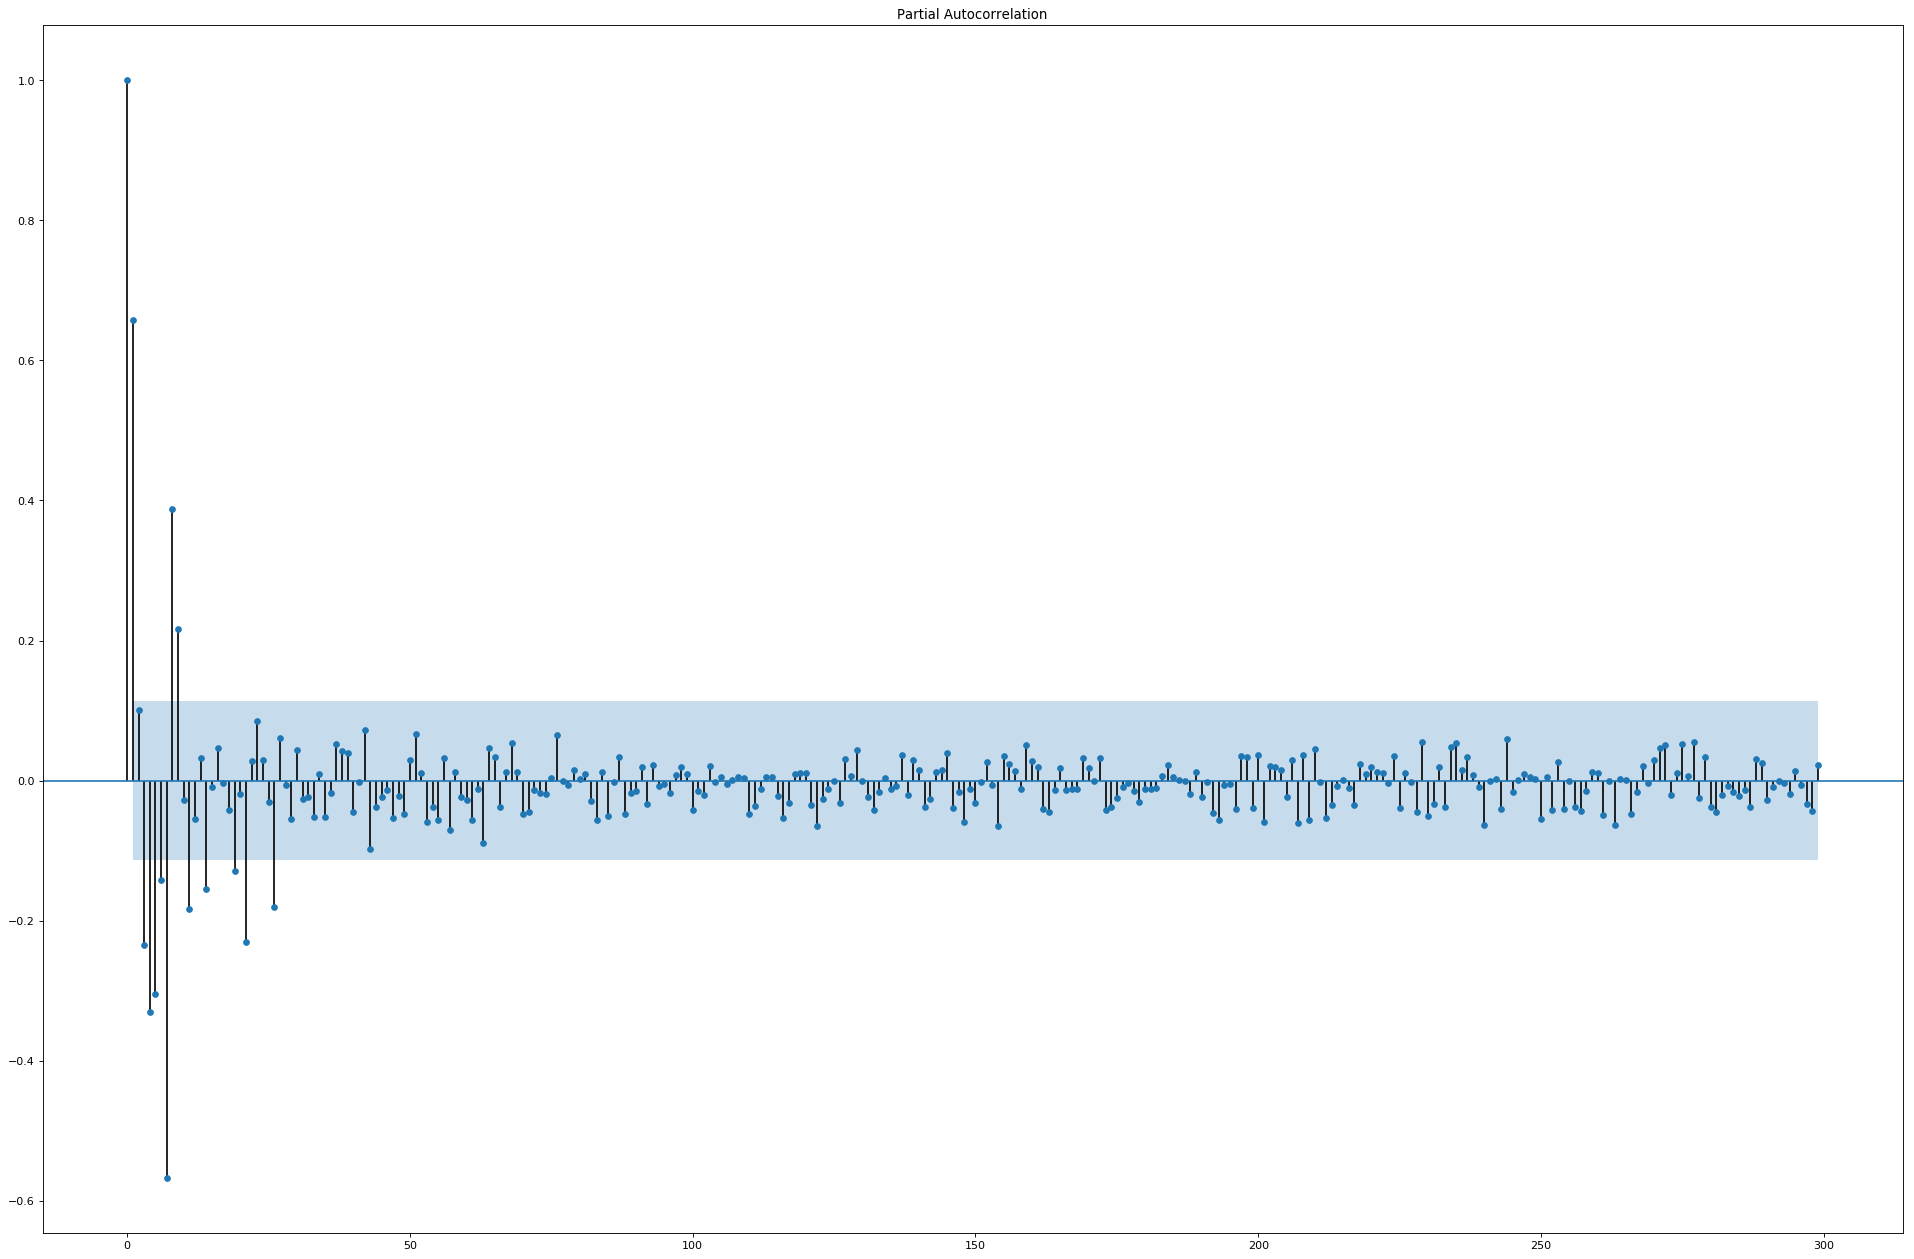

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(differenced[:300])
plt.show()

In [17]:
lags_ordered_importance = ['7','14','1','2','9','8','6','15','21','13','20']
dataset['t-'+str(lags_ordered_importance[1])]=dataset['NumberOfSales'].shift(int(lags_ordered_importance[1]))

In [18]:
lags_ordered_importance = ['7','14','1','2','9','8','6','15','21','13','20']
#using 8 lags for now, max n = 11
n_lags = 11
for i in range(n_lags):
    dataset['t-'+str(lags_ordered_importance[i])] = \
                dataset['NumberOfSales'].shift(int(lags_ordered_importance[i]))
    #dataset['t'] = series.values
    #dataset.head(20)
    #dataset = dataset[20:]
 


In [19]:
dataset =dataset[21:]

In [20]:
array = dataset.values

In [21]:
array[0:10,-n_lags:]

array([[8804.0, 6014.0, 8155.0, 9183.0, 6348.0, 4738.0, 6087.0, 9019.0,
        5676.0, 7823.0, 8111.0],
       [7823.0, 6087.0, 7109.0, 8155.0, 4738.0, 6014.0, 6962.0, 8804.0,
        8111.0, 7989.0, 8300.0],
       [7989.0, 6962.0, 8041.0, 7109.0, 6014.0, 6087.0, 6618.0, 7823.0,
        8300.0, 5895.0, 7154.0],
       [5895.0, 6618.0, 7890.0, 8041.0, 6087.0, 6962.0,
        7675.446488294315, 7989.0, 7154.0, 7675.446488294315,
        7675.446488294315],
       [7675.446488294315, 7675.446488294315, 6005.0, 7890.0, 6962.0,
        6618.0, 9183.0, 5895.0, 7675.446488294315, 6348.0, 10110.0],
       [6348.0, 9183.0, 7675.446488294315, 6005.0, 6618.0,
        7675.446488294315, 8155.0, 7675.446488294315, 10110.0, 4738.0,
        9019.0],
       [4738.0, 8155.0, 8550.0, 7675.446488294315, 7675.446488294315,
        9183.0, 7109.0, 6348.0, 9019.0, 6014.0, 8804.0],
       [6014.0, 7109.0, 8589.0, 8550.0, 9183.0, 8155.0, 8041.0, 4738.0,
        8804.0, 6087.0, 7823.0],
       [6087.0, 8041.

## Evaluating goodness of computed lag variables with Random Forest ensemble

In [22]:
from sklearn.ensemble import RandomForestRegressor
# load data
array = dataset.values
# split into input and output
X = array[:,-n_lags:]
y = array[:,10]
# fit random forest model
model = RandomForestRegressor(n_estimators=20, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)

[0.57257012 0.04285591 0.21566684 0.03153909 0.01539966 0.0202252
 0.016453   0.02423854 0.02923711 0.01755026 0.01426426]


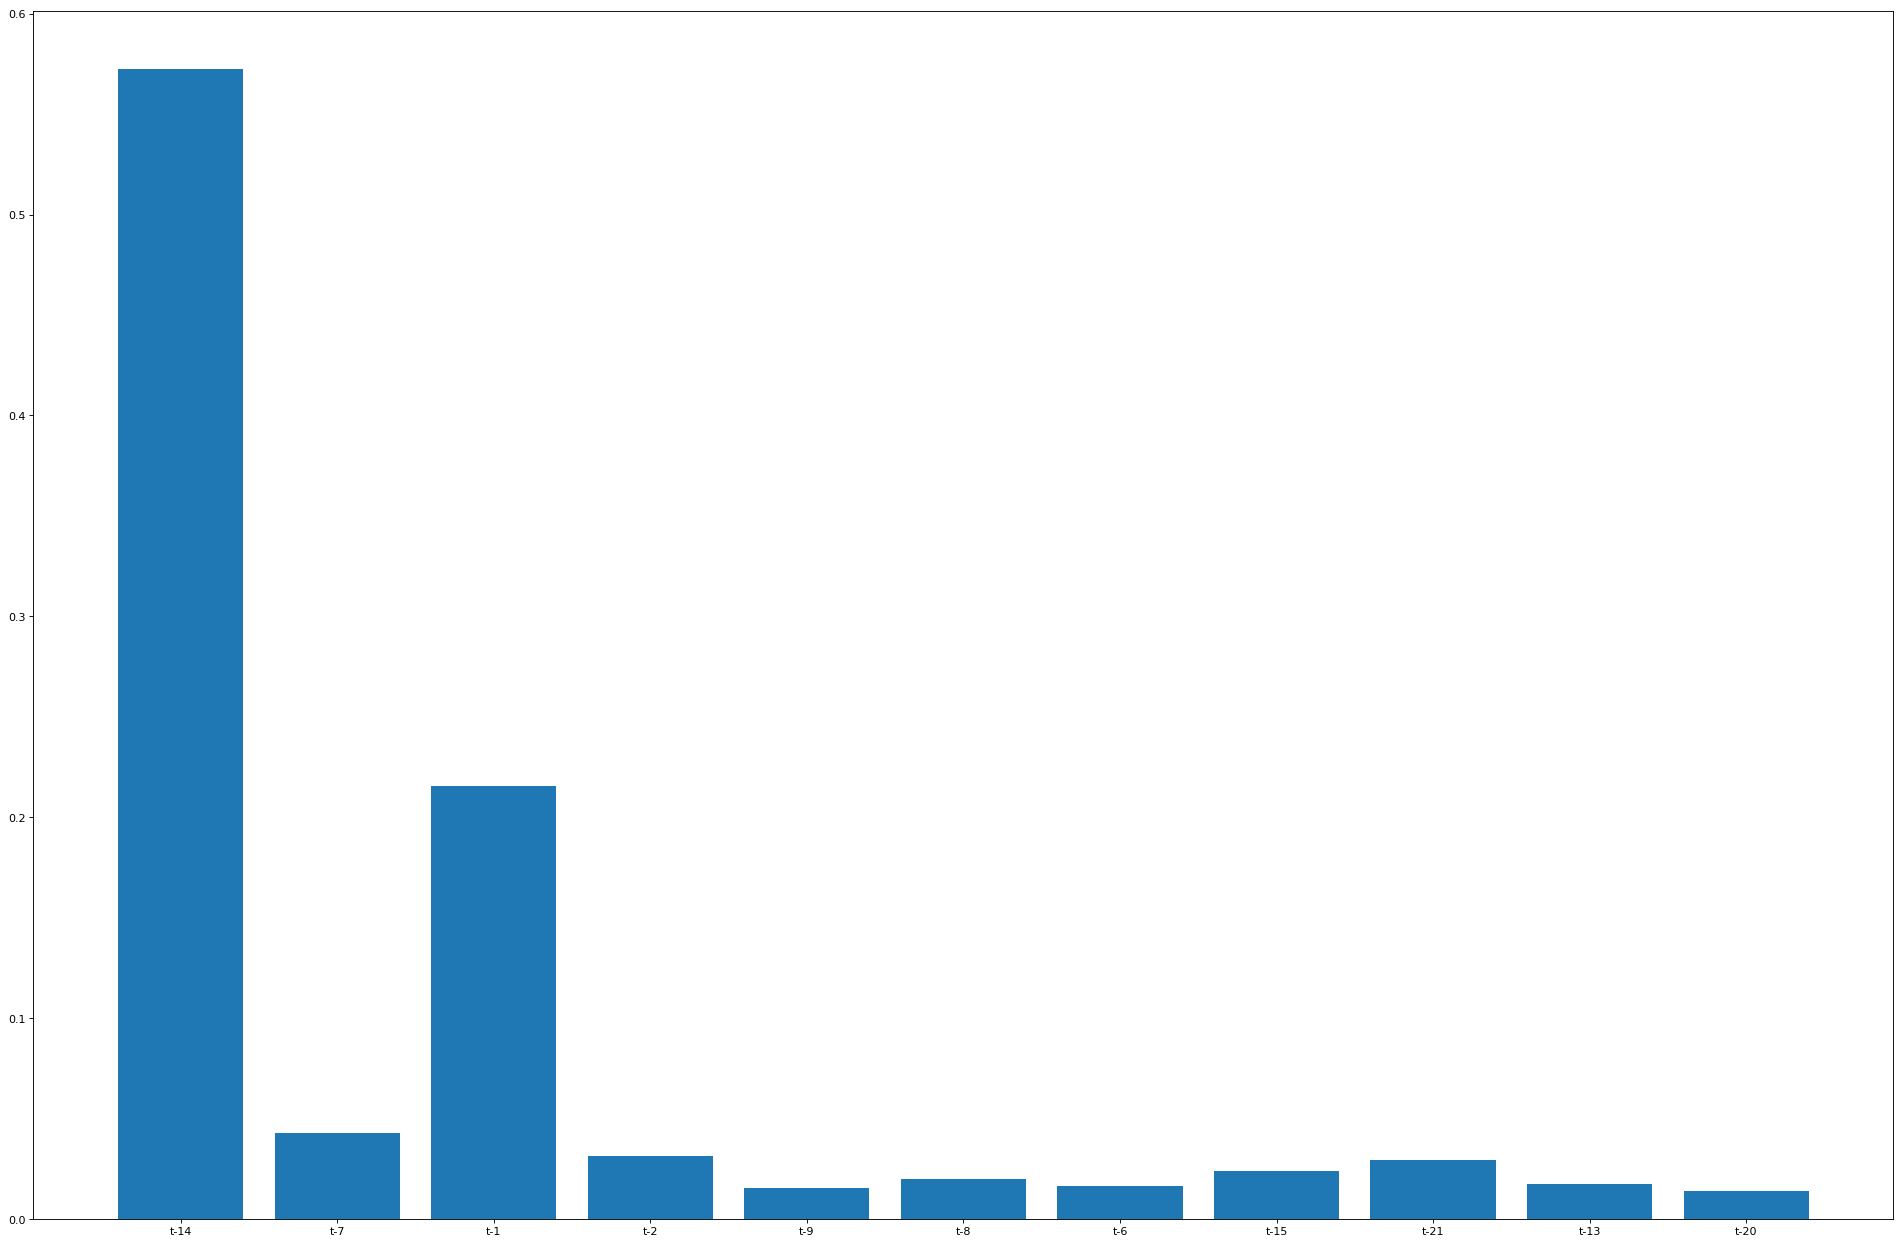

In [23]:
# plot importance scores
names = dataset.columns.values[-n_lags:]
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names)
plt.show()

As a stochastic result, a bit of difference with respect to what we predicted was expected, but the overall result seems solid

In [24]:
#dataset.to_csv('./dataset/ARIMA_prep_train.csv', index=False)
#dataset.to_csv('./dataset/preprocessed_train.csv', index=False)

In [26]:
pd.set_option('display.max_columns', 500)
dataset.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Events,Max_Dew_PointC,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Precipitationmm,WindDirDegrees,Day_of_week,Is_Friday,Is_Monday,Is_Saturday,Is_Sunday,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept,t-14,t-7,t-1,t-2,t-9,t-8,t-6,t-15,t-21,t-13,t-20
21,1000,2016-03-23,0,1,1,Hyper Market,General,326,7,541.000000,7109.000000,9643,17130,2770,6.0,Rain,6,100,1012,9,32,3,89,1004,5,21.0,10,-1,58,1001,1,5.08,191,Wednesday,0,0,0,0,0,0,1,0,1,0,0,1,0,0,8804.000000,6014.000000,8155.0,9183.0,6348.0,4738.0,6087.000000,9019.0,5676.000000,7823.000000,8111.000000
22,1000,2016-03-24,0,1,1,Hyper Market,General,326,7,626.000000,8041.000000,9643,17130,2770,6.0,Rain-Snow,0,87,1020,5,21,-2,71,1017,3,22.0,11,-4,51,1012,1,0.00,331,Thursday,0,0,0,0,1,0,0,0,1,0,0,1,0,0,7823.000000,6087.000000,7109.0,8155.0,4738.0,6014.0,6962.000000,8804.0,8111.000000,7989.000000,8300.000000
23,1000,2016-03-25,0,1,1,Hyper Market,General,326,7,625.000000,7890.000000,9643,17130,2770,5.0,None,-1,93,1020,7,34,-3,61,1016,3,23.0,14,-6,31,1014,-1,0.00,59,Friday,1,0,0,0,0,0,0,0,1,0,0,1,0,0,7989.000000,6962.000000,8041.0,7109.0,6014.0,6087.0,6618.000000,7823.0,8300.000000,5895.000000,7154.000000
24,1000,2016-03-26,0,1,0,Hyper Market,General,326,7,511.000000,6005.000000,9643,17130,2770,7.0,None,-5,64,1016,3,34,-7,52,1015,1,24.0,23,-10,34,1014,-1,0.00,67,Saturday,0,0,1,0,0,0,0,0,1,0,0,1,0,0,5895.000000,6618.000000,7890.0,8041.0,6087.0,6962.0,7675.446488,7989.0,7154.000000,7675.446488,7675.446488
25,1000,2016-03-27,0,0,0,Hyper Market,General,326,7,622.769231,7675.446488,9643,17130,2770,8.0,None,-10,48,1016,6,35,-12,34,1013,2,25.0,24,-14,13,1011,-2,0.00,59,Sunday,0,0,0,1,0,0,0,0,1,0,0,1,0,0,7675.446488,7675.446488,6005.0,7890.0,6962.0,6618.0,9183.000000,5895.0,7675.446488,6348.000000,10110.000000


## Dataset is becoming to large, we can drop some columns and since we already have the correctly shifted lag we can also redrop days in which originally the sales were 0

In [30]:
#dropped 8 not useful columns
dataset = dataset.drop(['StoreType', 'AssortmentType', 'Max_Sea_Level_PressurehPa',\
              'Min_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'WindDirDegrees', 'Max_Dew_PointC','Mean_Dew_PointC'], axis=1)

In [37]:
dataset = dataset.drop(['Min_Humidity'], axis=1)

In [38]:
dataset.shape

(433908, 50)

In [34]:
dataset = dataset.drop(dataset[dataset.NumberOfSales == 0].index)
dataset = dataset.drop(dataset[dataset.IsOpen == 0].index)

In [39]:
dataset.shape

(433908, 50)

### Already better, let's save it

In [60]:
dataset['Year'] = dataset['Date'].apply(lambda x: int(x[:4]))
dataset['Month'] = dataset['Date'].apply(lambda x: int(x[5:7]))
dataset['Day'] = dataset['Date'].apply(lambda x: int(x[8:10]))

In [62]:
dataset.iloc[0:10,-3:]

,Year,Month,Day
21,2016,3,23
22,2016,3,24
23,2016,3,25
24,2016,3,26
26,2016,3,28
27,2016,3,29
28,2016,3,30
29,2016,3,31
31,2016,4,2
34,2016,4,5


### Dropping the first 20 days of the observations for every store, (max lag)

In [63]:
d = dataset.drop(dataset[(dataset.Month == 3) & (dataset.Day < 21)].index)


In [64]:
d.shape

(409237, 53)

In [66]:
print("eliminated rows:")
433908-409237 

eliminated rows:


24671

In [67]:
dataset = d.drop(['Month','Day','Year'], axis=1)

In [68]:
dataset.shape

(409237, 50)

In [ ]:
dataset.to_csv('./dataset/ARIMA_prep_train.csv', index=False)